# Imports

In [1]:
# standard imports
import numpy as np
import os
import sys
import csv
import random
from collections import Counter
import pandas as pd
from datetime import datetime
from importlib import reload


# torch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary


# imports for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib.colors as mcolors
import matplotlib.transforms as mtransforms


# other imports
from tqdm.notebook import tqdm


# custom library imports
from library import plotting as pl
from library import earlyStopping as es
from library import getdata as gd
from library import elbo 
from library import att_LSTM_vae as att

# Environment

In [2]:
%load_ext watermark
%watermark -a "Author: Nicole Königstein" 
%watermark -d -v -m 
%watermark -v -p numpy,pandas

Author: Nicole Königstein
2022-05-15 

CPython 3.9.12
IPython 7.19.0

compiler   : Clang 13.1.6 (clang-1316.0.21.2)
system     : Darwin
release    : 21.1.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
CPython 3.9.12
IPython 7.19.0

numpy 1.19.5
pandas 1.2.3


# Helper functions

## Plotting

In [3]:
def results_plot(net, dataset, L=512, alpha=0.01, ELBO_loss=None):
    """
    This function plots the probability of the VAE from the following paper:
    https://www.joao-pereira.pt/publications/accepted_version_ICMLA18.pdf
    :param net: the neural network 
    :param dataset: the dataset to test the anomaly on e.g. test1
    :param L: the number for the Monte Carlo Method as an int
    :param alpha: the Log threshold
    :param ELBO_loss: the loss criterion for the network

    """
    # get all the simularity scores
    all_sim_scores = att.get_sim_scores(net, dataset, L=L, ELBO_loss=ELBO_loss)
    probs = all_sim_scores.flatten()  # flatten the tensor
    # get the anomaly index
    idx_anomaly = probs < np.log(alpha)
    x = np.arange(len(dataset.data))

    # init the plots
    fig, ax = plt.subplots(2, 1,
                           gridspec_kw=dict(
                               width_ratios=[1], height_ratios=[5, 1]),
                           figsize=(20, 5))
    fig.subplots_adjust(hspace=0, wspace=0.05)

    # normal data
    ax[0].plot(x, dataset.data, 'darkorange', label='Normal data')
    ax[0].set_xlim(np.min(x), np.max(x))

    # grey area to indiate the anomaly idx in the plot
    trans = mtransforms.blended_transform_factory(
        ax[0].transData, ax[0].transAxes)
    ax[0].fill_between(x, np.min(dataset.data), np.max(
        dataset.data), where=idx_anomaly, facecolor='lightgrey', alpha=0.5, transform=trans)

    # Get min and max similarity score
    min_sim = np.quantile(all_sim_scores, 0.02)
    max_sim = np.quantile(all_sim_scores, 0.9)

    # plot the e reconstruction probabiliy as an image
    ax[1].imshow(all_sim_scores.reshape(1, -1), aspect='auto',
                 cmap='RdYlGn', interpolation='spline16', vmin=min_sim, vmax=max_sim)
    ax[1].grid(False)
    ax[1].set_yticks([])
    ax[1].set_xticks([])

# Training Functions

In [4]:
def train(dataset, net, optimizer, criterion, batch_size, lamba_kl=0.01, num_workers=0, scheduler=None, scheduler_stop_step=np.inf):

    # Set network into training mode
    net.batch_size = batch_size
    net.init_hidden()
    net.train()

    # load the dataset
    loader = DataLoader(dataset=dataset, batch_size=batch_size,
                        shuffle=True, num_workers=num_workers)

    iter_ = 0
    for x, label in loader:

        # Cast to gpu if available
        if torch.cuda.is_available():
            x = x.to(torch.device(0))

        # Change batch size in last iteration
        if not x.shape[0] == batch_size:
            net.batch_size = x.shape[0]
            net.init_hidden()

        # Zero gradients
        optimizer.zero_grad()
        # Make forward pass with model
        outputs = net(x)
        # Calculate loss and backprop
        loss = criterion(x, outputs, 0.01, lamba_kl)
        loss.backward()
        optimizer.step()

        if scheduler and iter_ < scheduler_stop_step:
            scheduler.step()

        iter_ += 1

    # Revert to correct net batch size
    net.batch_size = batch_size
    net.init_hidden()

    return net


def validate(dataset, net, criterion, batch_size, lambda_kl=0.01):

    # Set network into evalution mode
    net.batch_size = batch_size
    net.init_hidden()
    net.eval()

    loader = DataLoader(dataset=dataset, batch_size=batch_size)

    total_loss = 0

    for x, label in loader:

        # Cast to gpu if available
        if torch.cuda.is_available():
            x = x.to(torch.device(0))

        # Change batch size in last iteration
        if not x.shape[0] == batch_size:
            net.batch_size = x.shape[0]
            net.init_hidden()

        # Make forward pass with model
        outputs = net(x)
        loss = criterion(x, outputs, 0.01, lambda_kl)
        total_loss += loss.item()

    # Set model to train mode and revert batch size
    net.batch_size = batch_size
    net.init_hidden()
    net.train()

    return total_loss/len(loader)


def train_validate(train_dataset, val_dataset, net, optimizer, criterion, n_epochs, batch_size,
                   num_workers=0, verbose=True,
                   scheduler=None, scheduler_stop_step=np.inf, patience=3, verbose_es=False, delta=3e-5):

    # initialize the early_stopping object
    early_stopping = es.EarlyStopping(
        patience=patience, verbose_es=verbose_es, delta=delta)

    train_losses = []
    val_losses = []
    lambda_kl = 0
    inc_val = 2/n_epochs

    for e in range(n_epochs):

        # Train model
        net = train(train_dataset, net, optimizer, criterion, batch_size,
                    lambda_kl, num_workers, scheduler, scheduler_stop_step)

        # Evaluate model on training data again and validate
        with torch.no_grad():
            train_loss = validate(train_dataset, net,
                                  criterion, batch_size, lambda_kl)
            val_loss = validate(val_dataset, net, criterion,
                                batch_size, lambda_kl)

            # early_stopping needs the validation loss to check if it has decresed,
            # and if it has, it will make a checkpoint of the current model
        early_stopping(val_loss, net)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        if verbose:
            print(
                "Epoch {0}/{1} \tTrain loss = {2:.3f}\tVal loss = {3:.3f}".format(
                    e+1, n_epochs, train_loss, val_loss)
            )

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        lambda_kl += inc_val

    return net, (train_losses, val_losses)

# Model training

In [5]:
# Set seed mu
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

T_w = 96  # Window length for the time series
batch_size = 100 

# just change here the file path to access the other data for
# all data used in the notebook for training, testing & plotting
filepath = "data2"

# choose a subset for the GetData Class to access train/val/test data
# smooth_window is used to smooth the time series with a moving average
train_data = gd.GetData(T_w, filepath, subset='train', smooth_window=0)
val_data = gd.GetData(T_w, filepath, subset='val', smooth_window=0)
model_path = "models"


# Model hyperparameters
n_epochs = 2500
z_dim = 3
h_dim = 128  # Number of LSTM units in each direction
x_dim = 1  # univariate (1) or multivariate (> 1)
lr = 0.001

# to easily change between the two distributions
normal = torch.distributions.normal.Normal
laplace = torch.distributions.laplace.Laplace

# change the ELBO Loss distribution
criterion = elbo.ELBO_distribution(pdf_distribution=laplace)
parameters = [z_dim, T_w, x_dim, h_dim, model_path, batch_size]
net = att.AttLSTMVAE(*parameters)

optimizer = torch.optim.Adam(net.parameters(), lr=lr, amsgrad=True)

# scheduler for Learning Rate Decay
# gamma -> Multiplicative factor of learning rate decay
scheduler = StepLR(optimizer, step_size=300, gamma=0.6)
patience = 50

# Train model
if torch.cuda.is_available():
    net = net.to(torch.device(0))

pars = {'train_dataset': train_data,
        'val_dataset': val_data,
        'net': net,
        'optimizer': optimizer,
        'criterion': criterion,
        'n_epochs': n_epochs,
        'batch_size': batch_size,
        'num_workers': 0,
        'verbose': True,
        'scheduler': scheduler,
        'patience': patience,
        'verbose_es': False,
        'delta': 0}

net, (train_losses, val_losses) = train_validate(**pars)

Epoch 1/2500 	Train loss = 0.910	Val loss = 0.904
Epoch 2/2500 	Train loss = 0.860	Val loss = 0.860
Epoch 3/2500 	Train loss = 0.822	Val loss = 0.821
Epoch 4/2500 	Train loss = 0.789	Val loss = 0.787
Epoch 5/2500 	Train loss = 0.759	Val loss = 0.756
Epoch 6/2500 	Train loss = 0.730	Val loss = 0.729
Epoch 7/2500 	Train loss = 0.698	Val loss = 0.700
Epoch 8/2500 	Train loss = 0.672	Val loss = 0.673
Epoch 9/2500 	Train loss = 0.646	Val loss = 0.646
Epoch 10/2500 	Train loss = 0.622	Val loss = 0.622
Epoch 11/2500 	Train loss = 0.600	Val loss = 0.598
Epoch 12/2500 	Train loss = 0.582	Val loss = 0.582
Epoch 13/2500 	Train loss = 0.575	Val loss = 0.571
Epoch 14/2500 	Train loss = 0.565	Val loss = 0.569
Epoch 15/2500 	Train loss = 0.551	Val loss = 0.550
Epoch 16/2500 	Train loss = 0.525	Val loss = 0.523
Epoch 17/2500 	Train loss = 0.494	Val loss = 0.499
Epoch 18/2500 	Train loss = 0.471	Val loss = 0.471
Epoch 19/2500 	Train loss = 0.443	Val loss = 0.445
Epoch 20/2500 	Train loss = 0.428	Val lo

Epoch 161/2500 	Train loss = 0.332	Val loss = 0.330
Epoch 162/2500 	Train loss = 0.330	Val loss = 0.330
Epoch 163/2500 	Train loss = 0.330	Val loss = 0.330
Epoch 164/2500 	Train loss = 0.329	Val loss = 0.330
Epoch 165/2500 	Train loss = 0.329	Val loss = 0.333
Epoch 166/2500 	Train loss = 0.334	Val loss = 0.333
Epoch 167/2500 	Train loss = 0.332	Val loss = 0.330
Epoch 168/2500 	Train loss = 0.332	Val loss = 0.326
Epoch 169/2500 	Train loss = 0.332	Val loss = 0.336
Epoch 170/2500 	Train loss = 0.331	Val loss = 0.333
Epoch 171/2500 	Train loss = 0.332	Val loss = 0.330
Epoch 172/2500 	Train loss = 0.327	Val loss = 0.331
Epoch 173/2500 	Train loss = 0.328	Val loss = 0.328
Epoch 174/2500 	Train loss = 0.334	Val loss = 0.331
Epoch 175/2500 	Train loss = 0.326	Val loss = 0.331
Epoch 176/2500 	Train loss = 0.328	Val loss = 0.335
Epoch 177/2500 	Train loss = 0.330	Val loss = 0.331
Epoch 178/2500 	Train loss = 0.329	Val loss = 0.326
Epoch 179/2500 	Train loss = 0.330	Val loss = 0.328
Epoch 180/25

Epoch 319/2500 	Train loss = 0.326	Val loss = 0.324
Epoch 320/2500 	Train loss = 0.329	Val loss = 0.330
Epoch 321/2500 	Train loss = 0.327	Val loss = 0.328
Epoch 322/2500 	Train loss = 0.327	Val loss = 0.327
Epoch 323/2500 	Train loss = 0.328	Val loss = 0.327
Epoch 324/2500 	Train loss = 0.328	Val loss = 0.328
Epoch 325/2500 	Train loss = 0.328	Val loss = 0.328
Epoch 326/2500 	Train loss = 0.327	Val loss = 0.328
Epoch 327/2500 	Train loss = 0.328	Val loss = 0.328
Epoch 328/2500 	Train loss = 0.326	Val loss = 0.328
Epoch 329/2500 	Train loss = 0.327	Val loss = 0.329
Epoch 330/2500 	Train loss = 0.328	Val loss = 0.325
Epoch 331/2500 	Train loss = 0.330	Val loss = 0.328
Epoch 332/2500 	Train loss = 0.327	Val loss = 0.328
Epoch 333/2500 	Train loss = 0.328	Val loss = 0.328
Epoch 334/2500 	Train loss = 0.330	Val loss = 0.328
Epoch 335/2500 	Train loss = 0.328	Val loss = 0.329
Epoch 336/2500 	Train loss = 0.330	Val loss = 0.329
Epoch 337/2500 	Train loss = 0.327	Val loss = 0.330
Epoch 338/25

Epoch 476/2500 	Train loss = -1.000	Val loss = -1.009
Epoch 477/2500 	Train loss = -1.122	Val loss = -1.028
Epoch 478/2500 	Train loss = -1.009	Val loss = -1.094
Epoch 479/2500 	Train loss = -0.812	Val loss = -0.780
Epoch 480/2500 	Train loss = -1.102	Val loss = -1.122
Epoch 481/2500 	Train loss = -0.846	Val loss = -0.813
Epoch 482/2500 	Train loss = -1.148	Val loss = -1.100
Epoch 483/2500 	Train loss = -0.834	Val loss = -0.893
Epoch 484/2500 	Train loss = -1.075	Val loss = -1.034
Epoch 485/2500 	Train loss = -0.905	Val loss = -0.955
Epoch 486/2500 	Train loss = -1.005	Val loss = -0.957
Epoch 487/2500 	Train loss = -1.023	Val loss = -1.026
Epoch 488/2500 	Train loss = -0.858	Val loss = -0.945
Epoch 489/2500 	Train loss = -1.037	Val loss = -1.097
Epoch 490/2500 	Train loss = -1.056	Val loss = -1.117
Epoch 491/2500 	Train loss = -1.100	Val loss = -1.055
Epoch 492/2500 	Train loss = -1.183	Val loss = -1.196
Epoch 493/2500 	Train loss = -1.046	Val loss = -1.047
Epoch 494/2500 	Train loss =

Epoch 628/2500 	Train loss = -1.765	Val loss = -1.801
Epoch 629/2500 	Train loss = -1.799	Val loss = -1.746
Epoch 630/2500 	Train loss = -1.502	Val loss = -1.557
Epoch 631/2500 	Train loss = -1.820	Val loss = -1.822
Epoch 632/2500 	Train loss = -1.408	Val loss = -1.471
Epoch 633/2500 	Train loss = -1.729	Val loss = -1.805
Epoch 634/2500 	Train loss = -1.696	Val loss = -1.486
Epoch 635/2500 	Train loss = -1.769	Val loss = -1.647
Epoch 636/2500 	Train loss = -1.749	Val loss = -1.708
Epoch 637/2500 	Train loss = -1.673	Val loss = -1.696
Epoch 638/2500 	Train loss = -1.828	Val loss = -1.775
Epoch 639/2500 	Train loss = -1.731	Val loss = -1.759
Epoch 640/2500 	Train loss = -1.708	Val loss = -1.756
Epoch 641/2500 	Train loss = -1.612	Val loss = -1.466
Epoch 642/2500 	Train loss = -1.813	Val loss = -1.861
Epoch 643/2500 	Train loss = -1.311	Val loss = -1.441
Epoch 644/2500 	Train loss = -1.827	Val loss = -1.800
Epoch 645/2500 	Train loss = -1.613	Val loss = -1.615
Epoch 646/2500 	Train loss =

Epoch 780/2500 	Train loss = -1.817	Val loss = -1.833
Epoch 781/2500 	Train loss = -1.597	Val loss = -1.712
Epoch 782/2500 	Train loss = -1.645	Val loss = -1.701
Epoch 783/2500 	Train loss = -1.924	Val loss = -1.842
Epoch 784/2500 	Train loss = -1.717	Val loss = -1.747
Epoch 785/2500 	Train loss = -1.837	Val loss = -1.780
Epoch 786/2500 	Train loss = -1.849	Val loss = -1.784
Epoch 787/2500 	Train loss = -1.888	Val loss = -1.853
Epoch 788/2500 	Train loss = -1.668	Val loss = -1.777
Epoch 789/2500 	Train loss = -1.860	Val loss = -1.910
Epoch 790/2500 	Train loss = -1.852	Val loss = -1.815
Epoch 791/2500 	Train loss = -1.916	Val loss = -1.884
Epoch 792/2500 	Train loss = -1.818	Val loss = -1.835
Epoch 793/2500 	Train loss = -1.847	Val loss = -1.790
Epoch 794/2500 	Train loss = -1.754	Val loss = -1.873
Epoch 795/2500 	Train loss = -1.682	Val loss = -1.763
Epoch 796/2500 	Train loss = -1.918	Val loss = -1.929
Epoch 797/2500 	Train loss = -1.887	Val loss = -1.830
Epoch 798/2500 	Train loss =

Epoch 932/2500 	Train loss = -1.974	Val loss = -2.025
Epoch 933/2500 	Train loss = -1.917	Val loss = -1.969
Epoch 934/2500 	Train loss = -1.948	Val loss = -1.995
Epoch 935/2500 	Train loss = -1.961	Val loss = -1.884
Epoch 936/2500 	Train loss = -2.018	Val loss = -1.877
Epoch 937/2500 	Train loss = -1.902	Val loss = -2.099
Epoch 938/2500 	Train loss = -1.831	Val loss = -2.003
Epoch 939/2500 	Train loss = -1.777	Val loss = -1.987
Epoch 940/2500 	Train loss = -1.999	Val loss = -1.962
Epoch 941/2500 	Train loss = -1.771	Val loss = -1.868
Epoch 942/2500 	Train loss = -1.993	Val loss = -1.938
Epoch 943/2500 	Train loss = -1.931	Val loss = -1.935
Epoch 944/2500 	Train loss = -2.035	Val loss = -1.990
Epoch 945/2500 	Train loss = -2.017	Val loss = -1.978
Epoch 946/2500 	Train loss = -1.923	Val loss = -1.797
Epoch 947/2500 	Train loss = -1.980	Val loss = -1.984
Epoch 948/2500 	Train loss = -1.954	Val loss = -1.929
Epoch 949/2500 	Train loss = -1.972	Val loss = -1.871
Epoch 950/2500 	Train loss =

Epoch 1083/2500 	Train loss = -1.573	Val loss = -1.581
Epoch 1084/2500 	Train loss = -1.688	Val loss = -1.766
Epoch 1085/2500 	Train loss = -2.025	Val loss = -1.908
Epoch 1086/2500 	Train loss = -2.009	Val loss = -2.073
Epoch 1087/2500 	Train loss = -1.951	Val loss = -1.753
Epoch 1088/2500 	Train loss = -1.904	Val loss = -1.751
Epoch 1089/2500 	Train loss = -2.063	Val loss = -1.992
Epoch 1090/2500 	Train loss = -1.893	Val loss = -1.911
Epoch 1091/2500 	Train loss = -2.080	Val loss = -1.856
Epoch 1092/2500 	Train loss = -2.071	Val loss = -2.000
Epoch 1093/2500 	Train loss = -1.972	Val loss = -1.918
Epoch 1094/2500 	Train loss = -1.966	Val loss = -1.863
Epoch 1095/2500 	Train loss = -2.015	Val loss = -1.997
Epoch 1096/2500 	Train loss = -1.981	Val loss = -2.049
Epoch 1097/2500 	Train loss = -2.040	Val loss = -1.911
Epoch 1098/2500 	Train loss = -1.940	Val loss = -1.809
Epoch 1099/2500 	Train loss = -1.954	Val loss = -2.068
Epoch 1100/2500 	Train loss = -1.830	Val loss = -1.936
Epoch 1101

Epoch 1232/2500 	Train loss = -2.004	Val loss = -2.180
Epoch 1233/2500 	Train loss = -2.075	Val loss = -2.175
Epoch 1234/2500 	Train loss = -2.050	Val loss = -1.997
Epoch 1235/2500 	Train loss = -2.120	Val loss = -1.949
Epoch 1236/2500 	Train loss = -1.934	Val loss = -2.102
Epoch 1237/2500 	Train loss = -2.107	Val loss = -2.251
Epoch 1238/2500 	Train loss = -2.084	Val loss = -2.089
Epoch 1239/2500 	Train loss = -2.122	Val loss = -1.894
Epoch 1240/2500 	Train loss = -2.014	Val loss = -2.058
Epoch 1241/2500 	Train loss = -2.034	Val loss = -2.131
Epoch 1242/2500 	Train loss = -2.179	Val loss = -2.166
Epoch 1243/2500 	Train loss = -2.077	Val loss = -2.202
Epoch 1244/2500 	Train loss = -2.086	Val loss = -2.146
Epoch 1245/2500 	Train loss = -2.137	Val loss = -2.116
Epoch 1246/2500 	Train loss = -1.966	Val loss = -2.242
Epoch 1247/2500 	Train loss = -2.246	Val loss = -2.225
Epoch 1248/2500 	Train loss = -1.926	Val loss = -2.071
Epoch 1249/2500 	Train loss = -2.044	Val loss = -2.060
Epoch 1250

Epoch 1381/2500 	Train loss = -2.085	Val loss = -2.056
Epoch 1382/2500 	Train loss = -2.171	Val loss = -2.133
Epoch 1383/2500 	Train loss = -2.143	Val loss = -2.122
Epoch 1384/2500 	Train loss = -2.234	Val loss = -2.186
Epoch 1385/2500 	Train loss = -2.038	Val loss = -2.054
Epoch 1386/2500 	Train loss = -2.045	Val loss = -2.069
Epoch 1387/2500 	Train loss = -1.982	Val loss = -2.105
Epoch 1388/2500 	Train loss = -2.195	Val loss = -2.079
Epoch 1389/2500 	Train loss = -2.179	Val loss = -2.042
Epoch 1390/2500 	Train loss = -2.059	Val loss = -2.150
Epoch 1391/2500 	Train loss = -2.069	Val loss = -2.110
Epoch 1392/2500 	Train loss = -1.786	Val loss = -2.002
Epoch 1393/2500 	Train loss = -2.111	Val loss = -2.104
Epoch 1394/2500 	Train loss = -1.997	Val loss = -2.282
Epoch 1395/2500 	Train loss = -2.084	Val loss = -2.110
Epoch 1396/2500 	Train loss = -2.248	Val loss = -2.170
Epoch 1397/2500 	Train loss = -2.152	Val loss = -2.160
Epoch 1398/2500 	Train loss = -2.168	Val loss = -2.176
Epoch 1399

Epoch 1530/2500 	Train loss = -2.197	Val loss = -2.294
Epoch 1531/2500 	Train loss = -2.248	Val loss = -2.123
Epoch 1532/2500 	Train loss = -2.250	Val loss = -2.156
Epoch 1533/2500 	Train loss = -2.174	Val loss = -2.275
Epoch 1534/2500 	Train loss = -2.154	Val loss = -2.246
Epoch 1535/2500 	Train loss = -2.405	Val loss = -2.151
Epoch 1536/2500 	Train loss = -2.306	Val loss = -2.213
Epoch 1537/2500 	Train loss = -2.248	Val loss = -2.306
Epoch 1538/2500 	Train loss = -2.196	Val loss = -1.968
Epoch 1539/2500 	Train loss = -2.027	Val loss = -1.829
Epoch 1540/2500 	Train loss = -2.308	Val loss = -2.336
Epoch 1541/2500 	Train loss = -2.274	Val loss = -2.204
Epoch 1542/2500 	Train loss = -2.229	Val loss = -2.282
Epoch 1543/2500 	Train loss = -2.275	Val loss = -2.207
Epoch 1544/2500 	Train loss = -2.316	Val loss = -2.326
Epoch 1545/2500 	Train loss = -2.214	Val loss = -2.236
Epoch 1546/2500 	Train loss = -2.310	Val loss = -2.174
Epoch 1547/2500 	Train loss = -2.326	Val loss = -2.282
Epoch 1548

Epoch 1679/2500 	Train loss = -2.352	Val loss = -2.340
Epoch 1680/2500 	Train loss = -2.277	Val loss = -2.204
Epoch 1681/2500 	Train loss = -2.372	Val loss = -2.407
Epoch 1682/2500 	Train loss = -2.317	Val loss = -2.314
Epoch 1683/2500 	Train loss = -2.337	Val loss = -2.268
Epoch 1684/2500 	Train loss = -2.160	Val loss = -2.315
Epoch 1685/2500 	Train loss = -2.211	Val loss = -2.201
Epoch 1686/2500 	Train loss = -2.349	Val loss = -2.272
Epoch 1687/2500 	Train loss = -2.389	Val loss = -2.386
Epoch 1688/2500 	Train loss = -2.450	Val loss = -2.277
Epoch 1689/2500 	Train loss = -2.272	Val loss = -2.258
Epoch 1690/2500 	Train loss = -2.284	Val loss = -2.431
Epoch 1691/2500 	Train loss = -2.231	Val loss = -2.249
Epoch 1692/2500 	Train loss = -2.180	Val loss = -2.233
Epoch 1693/2500 	Train loss = -2.336	Val loss = -2.329
Epoch 1694/2500 	Train loss = -2.441	Val loss = -2.432
Epoch 1695/2500 	Train loss = -2.281	Val loss = -2.306
Epoch 1696/2500 	Train loss = -2.363	Val loss = -2.401
Epoch 1697

Epoch 1828/2500 	Train loss = -2.440	Val loss = -2.427
Epoch 1829/2500 	Train loss = -2.428	Val loss = -2.425
Epoch 1830/2500 	Train loss = -2.471	Val loss = -2.317
Epoch 1831/2500 	Train loss = -2.422	Val loss = -2.500
Epoch 1832/2500 	Train loss = -2.538	Val loss = -2.522
Epoch 1833/2500 	Train loss = -2.411	Val loss = -2.344
Epoch 1834/2500 	Train loss = -2.488	Val loss = -2.537
Epoch 1835/2500 	Train loss = -2.474	Val loss = -2.423
Epoch 1836/2500 	Train loss = -2.409	Val loss = -2.428
Epoch 1837/2500 	Train loss = -2.491	Val loss = -2.555
Epoch 1838/2500 	Train loss = -2.452	Val loss = -2.412
Epoch 1839/2500 	Train loss = -2.432	Val loss = -2.441
Epoch 1840/2500 	Train loss = -2.424	Val loss = -2.373
Epoch 1841/2500 	Train loss = -2.466	Val loss = -2.546
Epoch 1842/2500 	Train loss = -2.498	Val loss = -2.356
Epoch 1843/2500 	Train loss = -2.283	Val loss = -2.419
Epoch 1844/2500 	Train loss = -2.460	Val loss = -2.411
Epoch 1845/2500 	Train loss = -2.422	Val loss = -2.500
Epoch 1846

Epoch 1977/2500 	Train loss = -2.594	Val loss = -2.304
Epoch 1978/2500 	Train loss = -2.372	Val loss = -2.409
Epoch 1979/2500 	Train loss = -2.342	Val loss = -2.497
Epoch 1980/2500 	Train loss = -2.327	Val loss = -2.481
Epoch 1981/2500 	Train loss = -2.321	Val loss = -2.195
Epoch 1982/2500 	Train loss = -2.247	Val loss = -2.364
Epoch 1983/2500 	Train loss = -2.359	Val loss = -2.411
Epoch 1984/2500 	Train loss = -2.481	Val loss = -2.475
Epoch 1985/2500 	Train loss = -2.587	Val loss = -2.540
Epoch 1986/2500 	Train loss = -2.606	Val loss = -2.496
Epoch 1987/2500 	Train loss = -2.584	Val loss = -2.437
Epoch 1988/2500 	Train loss = -2.444	Val loss = -2.538
Epoch 1989/2500 	Train loss = -2.497	Val loss = -2.532
Epoch 1990/2500 	Train loss = -2.518	Val loss = -2.438
Epoch 1991/2500 	Train loss = -2.587	Val loss = -2.511
Epoch 1992/2500 	Train loss = -2.436	Val loss = -2.468
Epoch 1993/2500 	Train loss = -2.472	Val loss = -2.497
Epoch 1994/2500 	Train loss = -2.359	Val loss = -2.450
Epoch 1995

Epoch 2126/2500 	Train loss = -2.643	Val loss = -2.628
Epoch 2127/2500 	Train loss = -2.683	Val loss = -2.677
Epoch 2128/2500 	Train loss = -2.523	Val loss = -2.661
Epoch 2129/2500 	Train loss = -2.534	Val loss = -2.544
Epoch 2130/2500 	Train loss = -2.532	Val loss = -2.682
Epoch 2131/2500 	Train loss = -2.653	Val loss = -2.650
Epoch 2132/2500 	Train loss = -2.523	Val loss = -2.534
Epoch 2133/2500 	Train loss = -2.608	Val loss = -2.560
Epoch 2134/2500 	Train loss = -2.604	Val loss = -2.587
Epoch 2135/2500 	Train loss = -2.650	Val loss = -2.622
Epoch 2136/2500 	Train loss = -2.541	Val loss = -2.503
Epoch 2137/2500 	Train loss = -2.557	Val loss = -2.659
Epoch 2138/2500 	Train loss = -2.573	Val loss = -2.548
Epoch 2139/2500 	Train loss = -2.646	Val loss = -2.615
Epoch 2140/2500 	Train loss = -2.664	Val loss = -2.585
Epoch 2141/2500 	Train loss = -2.629	Val loss = -2.402
Epoch 2142/2500 	Train loss = -2.633	Val loss = -2.544
Epoch 2143/2500 	Train loss = -2.503	Val loss = -2.599
Epoch 2144

Epoch 2275/2500 	Train loss = -2.667	Val loss = -2.568
Epoch 2276/2500 	Train loss = -2.688	Val loss = -2.545
Epoch 2277/2500 	Train loss = -2.509	Val loss = -2.629
Epoch 2278/2500 	Train loss = -2.672	Val loss = -2.654
Epoch 2279/2500 	Train loss = -2.700	Val loss = -2.583
Epoch 2280/2500 	Train loss = -2.681	Val loss = -2.712
Epoch 2281/2500 	Train loss = -2.678	Val loss = -2.557
Epoch 2282/2500 	Train loss = -2.635	Val loss = -2.579
Epoch 2283/2500 	Train loss = -2.582	Val loss = -2.631
Epoch 2284/2500 	Train loss = -2.575	Val loss = -2.620
Epoch 2285/2500 	Train loss = -2.538	Val loss = -2.592
Epoch 2286/2500 	Train loss = -2.550	Val loss = -2.606
Epoch 2287/2500 	Train loss = -2.505	Val loss = -2.562
Epoch 2288/2500 	Train loss = -2.710	Val loss = -2.566
Epoch 2289/2500 	Train loss = -2.705	Val loss = -2.516
Epoch 2290/2500 	Train loss = -2.699	Val loss = -2.621
Epoch 2291/2500 	Train loss = -2.648	Val loss = -2.553
Epoch 2292/2500 	Train loss = -2.673	Val loss = -2.673
Epoch 2293

Epoch 2424/2500 	Train loss = -2.593	Val loss = -2.533
Epoch 2425/2500 	Train loss = -2.687	Val loss = -2.520
Epoch 2426/2500 	Train loss = -2.591	Val loss = -2.549
Epoch 2427/2500 	Train loss = -2.597	Val loss = -2.495
Epoch 2428/2500 	Train loss = -2.673	Val loss = -2.806
Epoch 2429/2500 	Train loss = -2.689	Val loss = -2.772
Epoch 2430/2500 	Train loss = -2.668	Val loss = -2.636
Epoch 2431/2500 	Train loss = -2.699	Val loss = -2.615
Epoch 2432/2500 	Train loss = -2.552	Val loss = -2.567
Epoch 2433/2500 	Train loss = -2.573	Val loss = -2.453
Epoch 2434/2500 	Train loss = -2.664	Val loss = -2.537
Epoch 2435/2500 	Train loss = -2.632	Val loss = -2.549
Epoch 2436/2500 	Train loss = -2.681	Val loss = -2.701
Epoch 2437/2500 	Train loss = -2.673	Val loss = -2.723
Epoch 2438/2500 	Train loss = -2.697	Val loss = -2.771
Epoch 2439/2500 	Train loss = -2.739	Val loss = -2.615
Epoch 2440/2500 	Train loss = -2.650	Val loss = -2.645
Epoch 2441/2500 	Train loss = -2.664	Val loss = -2.682
Epoch 2442

# Plot training history

In [6]:
min_ = min(train_losses)
max_ = max(train_losses)
ticks = np.arange(min_, max_+1)

# print the train and val losses mean values
print(np.mean(train_losses))
print(np.mean(val_losses))

y = np.arange(min_, max_+1, 1)

-1.6973433625940233
-1.698938741749525


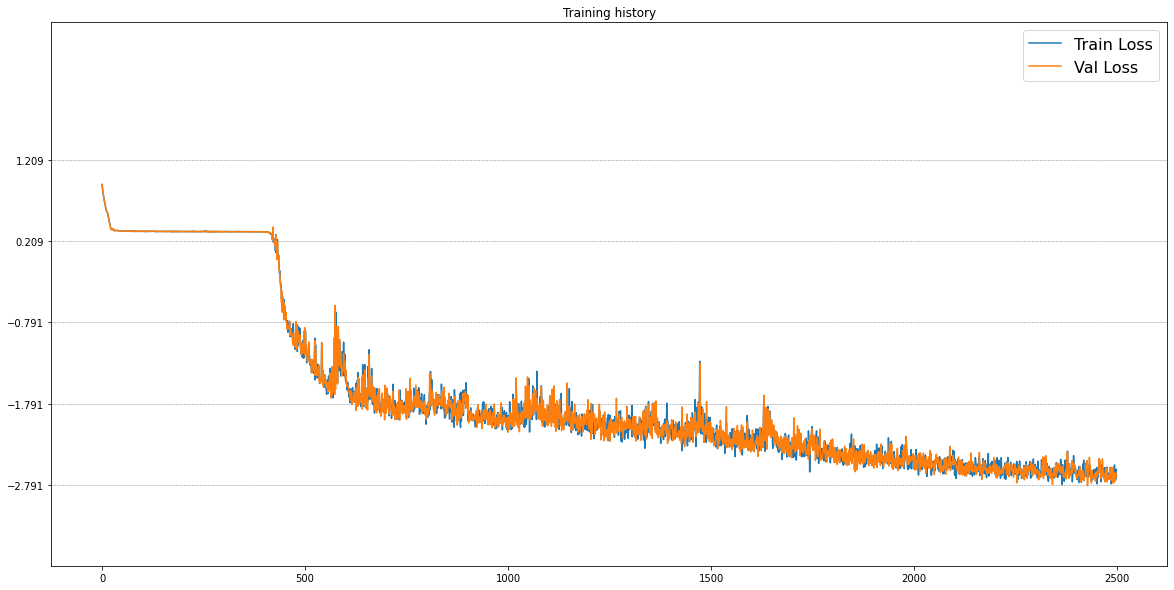

In [7]:
plt.figure(figsize=(20, 10))
plt.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.ylim(min_-1, max_+2)
plt.yticks(ticks)
plt.legend(fontsize=16)
plt.title('Training history');

In [8]:
pl.model_summary(net)

Model summary
------------------------------------------------------------------------------------------------------------------------
Layer Name                              	Layer Shape                             	# Parameters                            
------------------------------------------------------------------------------------------------------------------------
LSTM_encoder.weight_ih_l0               	(512, 1)                                	512                                     
LSTM_encoder.weight_hh_l0               	(512, 128)                              	65536                                   
LSTM_encoder.bias_ih_l0                 	(512,)                                  	512                                     
LSTM_encoder.bias_hh_l0                 	(512,)                                  	512                                     
LSTM_encoder.weight_ih_l0_reverse       	(512, 1)                                	512                                     
LSTM_e

## Load test data and calculate sim score

  0%|          | 0/9 [00:00<?, ?it/s]

Patience 1/5
Difference in averages in MC simulation was higher than Tolerance 1.000e-03


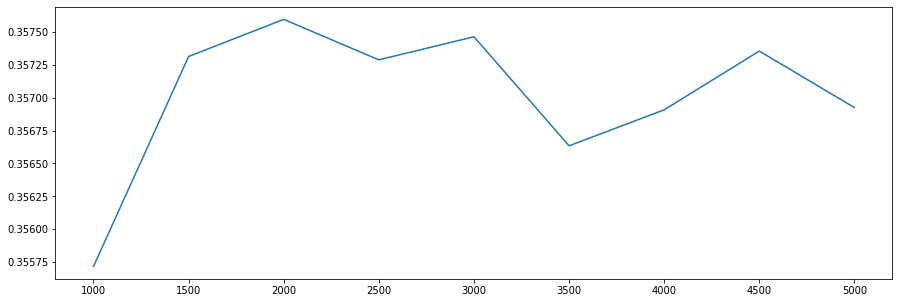

threshold =  0.35705700203217317
best L =  5000


In [9]:
# Monte Carlo approach to find the reconstruction threshold

# log-prob threshold
L_values = []
min_probs = []
TOL = 1e-3

prev_avg = np.inf
best_L = 0
patience = 0
PATIENCE_LIMIT = 5
for L in tqdm(np.arange(1000, 5000+500, 500, dtype=np.int64)):
    sim_scores = att.get_sim_scores(net, train_data, L=L, ELBO_loss=criterion)
    min_probs.append(np.min(np.exp(sim_scores)))
    actual_avg = np.mean(np.exp(sim_scores))

    best_L = L
    error = abs(actual_avg - prev_avg)
    L_values.append(L)
    if error < TOL:
        patience += 1
        print(f'Patience {patience}/{PATIENCE_LIMIT}')
        if patience == PATIENCE_LIMIT:

            break

    prev_avg = actual_avg

if error >= TOL:
    print(
        f'Difference in averages in MC simulation was higher than Tolerance {TOL:.3e}')


threshold = np.mean(min_probs[-PATIENCE_LIMIT:])  # use last five values


plt.figure(figsize=(15, 5))

plt.plot(L_values, min_probs)
plt.show()

print('threshold = ', threshold)
print('best L = ', best_L)

# Plot probability threshold


Saving figure:  reconstruction-no-labels-best-L-laplace


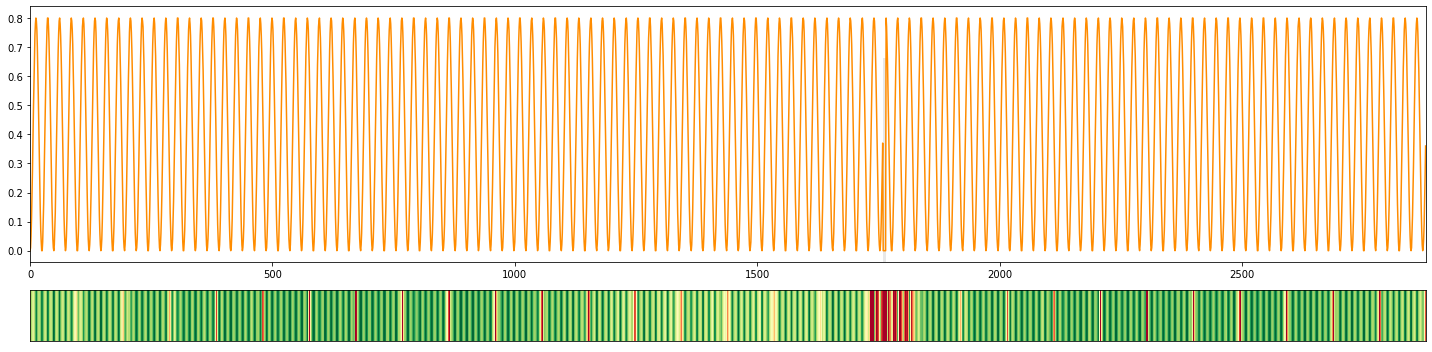

In [10]:
test_data = gd.GetData(T_w, filepath, subset='test')
results_plot(net, test_data, L=best_L, alpha=threshold, ELBO_loss=criterion)
pl.save_fig('reconstruction-no-labels-best-L-laplace')

# Plot attention weights Visualization

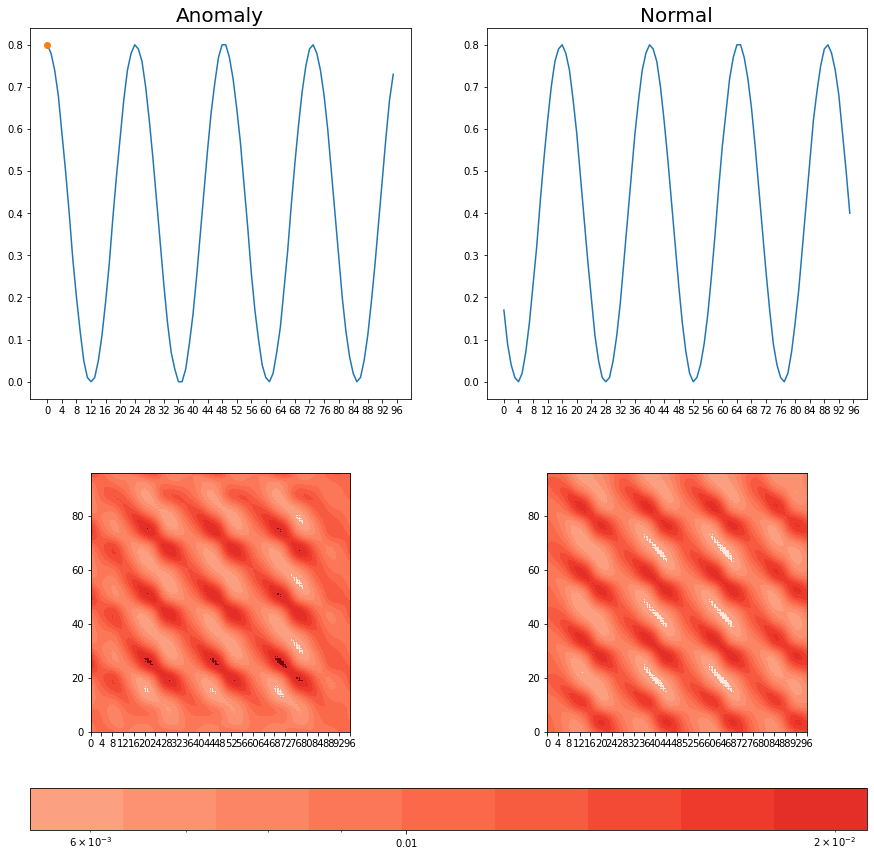

In [11]:
dataset = test_data

batch_size = min((len(dataset), dataset.T_w*100))

loader = DataLoader(dataset, shuffle=False, batch_size=batch_size)

# Re-initialize network
net.batch_size = batch_size
net.init_hidden()
net.eval()
#all_sim_scores = get_sim_scores(net, dataset, L=L, ELBO_loss=ELBO_loss)

attention_anomaly = None
anomaly_regular = None

for x, label in loader:
    # Modify batch size and hidden state
    if x.shape[0] != batch_size:
        net.batch_size = x.shape[0]
        net.init_hidden()

    # Cast to gpu if available

    if torch.cuda.is_available():
        x = x.to(torch.device(0))

    temp_sim = att.tensor2numpy(att.similarity_score(
        net, x, best_L, criterion)).reshape(-1, dataset.T_w)
    anomaly_row, anomaly_col = np.where(temp_sim < np.log(threshold))
    sel_idx_anomaly = np.random.choice(anomaly_row)
    regular_row = np.delete(np.arange(x.shape[0]), anomaly_row)
    sel_idx_regular = np.random.choice(regular_row)

    if (temp_sim < threshold).any():
        # print(temp_sim.shape)

        X = x[sel_idx_anomaly, :, :].view(1, -1, 1)

        # print(anomaly_idx)
        # input()
        with torch.no_grad():
            net.batch_size = X.shape[0]
            net.init_hidden()
            attention_anomaly = net(X)['A']

    X = x[sel_idx_regular, :, :].view(1, -1, 1)

    # print(anomaly_idx)
    # input()
    with torch.no_grad():
        net.batch_size = X.shape[0]
        net.init_hidden()
        attention_regular = net(X)['A']

    if attention_anomaly is not None and attention_regular is not None:
        break


# assuming one batch only, so no need to concatenate the attention variable
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# even bounds gives a contour-like effect
bounds = np.linspace(-4, 4, 24)
# get one more color than bounds from colormap
colors = plt.get_cmap('Reds')(np.linspace(0, 1, len(bounds)+1))
# create colormap without custom color bounds
cmap = mcolors.ListedColormap(colors[8:-8])

# set upper/lower color
cmap.set_over(colors[-2])
cmap.set_under(colors[2])

# create norm from bounds
anomaly_min = att.tensor2numpy(attention_anomaly).reshape(
    dataset.T_w, dataset.T_w).T.min()
anomaly_max = att.tensor2numpy(attention_anomaly).reshape(
    dataset.T_w, dataset.T_w).T.max()

regular_min = att.tensor2numpy(attention_regular).reshape(
    dataset.T_w, dataset.T_w).T.min()
regular_max = att.tensor2numpy(attention_regular).reshape(
    dataset.T_w, dataset.T_w).T.max()

v_min = anomaly_min if anomaly_min < regular_min else regular_min
v_max = anomaly_max if anomaly_max > regular_max else regular_max

#v_min = tensor2numpy(attention_regular).reshape(dataset.T_w,dataset.T_w).T.min()
#v_max = tensor2numpy(attention_regular).reshape(dataset.T_w,dataset.T_w).T.max()

norm = mcolors.LogNorm(vmin=v_min, vmax=v_max)
extent = (0, T_w, 0, T_w)

# print(tensor2numpy(attention).T.shape)
anomaly_data = att.tensor2numpy(
    x[sel_idx_anomaly, :, :].view(1, -1, 1)).reshape(-1)
regular_data = att.tensor2numpy(
    x[sel_idx_regular, :, :].view(1, -1, 1)).reshape(-1)

x = np.arange(len(regular_data))
axs[0][0].plot(x, anomaly_data)
axs[0][0].plot(x[anomaly_col[anomaly_row == sel_idx_anomaly]],
               anomaly_data[anomaly_col[anomaly_row == sel_idx_anomaly]], 'o')
img = axs[1][0].imshow(att.tensor2numpy(attention_anomaly).reshape(dataset.T_w, dataset.T_w).T,
                       norm=norm, cmap=cmap, interpolation='sinc', aspect='equal', origin='upper', extent=extent)
axs[0][0].set_title('Anomaly', fontsize=20)
fig.colorbar(img, ax=axs[1], orientation='horizontal', format='$%.2f$')
axs[0][0].set_xticks(np.arange(0, T_w + 1, 4.0))
axs[1][0].set_xticks(np.arange(0, T_w + 1, 4.0))

axs[0][1].plot(x, regular_data)
axs[1][1].imshow(att.tensor2numpy(attention_regular).reshape(dataset.T_w, dataset.T_w).T,
                 norm=norm, cmap=cmap, interpolation='sinc', aspect='equal', origin='upper', extent=extent)
axs[0][1].set_title('Normal', fontsize=20)
axs[0][1].set_xticks(np.arange(0, T_w + 1, 4.0))
axs[1][1].set_xticks(np.arange(0, T_w + 1, 4.0))
plt.show()

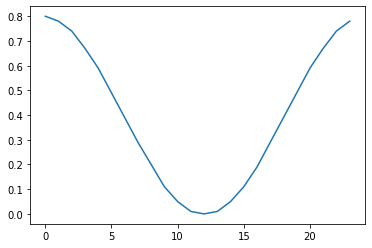

In [12]:
x = np.arange(24)
plt.plot(x, regular_data[16:40]);

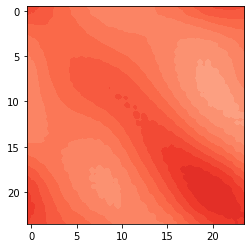

In [13]:
plt.imshow(att.tensor2numpy(attention_anomaly[0, :24, :24]).T, norm=norm,
           cmap=cmap, interpolation='sinc', aspect='equal', origin='upper');